Referanslar:


*   https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_deeplabv3_resnet101.ipynb
*   https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
* https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/







In [2]:
import torch
model = torch.hub.load('pytorch/vision', 'fcn_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:03<00:00, 53469257.74it/s]
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 217800805/217800805 [00:07<00:00, 29447355.67it/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
      

In [3]:
from google.colab import files
uploaded = files.upload()

Saving output.mp4 to output.mp4


In [0]:
import cv2
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [0]:
import numpy as np
from PIL import Image


In [0]:
video_okuyucu = cv2.VideoCapture('output.mp4')

video_list = []
video_list_orig = []


counter = 50
while(video_okuyucu.isOpened()):
  # Capture frame-by-frame
  ret, frame = video_okuyucu.read()
  
  if ret:
    
    frame = img = cv2.resize(frame,None,fx=0.25,fy=0.25)
  
    video_list.append(preprocess(frame))
    video_list_orig.append(frame)
    
  else: 
    break
  
  if counter == 1:
      break
  
  counter += 1
  
  
video_tensor = torch.ones((len(video_list), video_list[0].shape[0], video_list[0].shape[1], video_list[0].shape[2]))


for i, frame in enumerate(video_list):
  video_tensor[i] = frame



torch.Size([301, 180, 320])


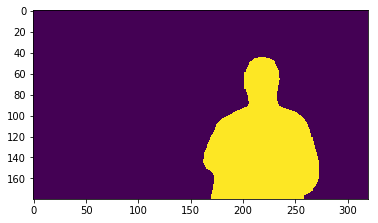

In [7]:
if torch.cuda.is_available():
    video_tensor = video_tensor.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(video_tensor)['out']
output_predictions = output.argmax(1).cpu()


output_predictions = (output_predictions==15) # insan pixellerini secelim

r = Image.fromarray(output_predictions[0].byte().cpu().numpy()).resize(list(video_list[0].shape[1:3][::-1]))

import matplotlib.pyplot as plt
plt.imshow(r)

print(output_predictions.shape)

In [9]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Kordon_%28ekim_2009%29_2_-_panoramio.jpg/256px-Kordon_%28ekim_2009%29_2_-_panoramio.jpg

--2019-09-14 16:20:37--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Kordon_%28ekim_2009%29_2_-_panoramio.jpg/256px-Kordon_%28ekim_2009%29_2_-_panoramio.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15472 (15K) [image/jpeg]
Saving to: ‘256px-Kordon_(ekim_2009)_2_-_panoramio.jpg’

256px-Kordon_(ekim_ 100%[===================>]  15.11K  --.-KB/s    in 0s      

2019-09-14 16:20:37 (88.7 MB/s) - ‘256px-Kordon_(ekim_2009)_2_-_panoramio.jpg’ saved [15472/15472]



In [0]:
arka_plan = cv2.imread('256px-Kordon_(ekim_2009)_2_-_panoramio.jpg')

arka_plan = cv2.resize(arka_plan, (320,180))

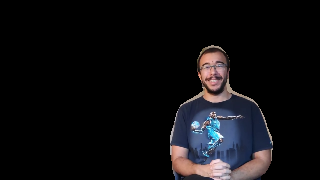

In [11]:
from copy import deepcopy

video_tensor = video_tensor.cpu()

video_yaratici = cv2.VideoWriter('cikti.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, tuple(video_list[0].shape[1:3][::-1]))

video_list_orig_cpy = deepcopy(video_list_orig)

for i, out in enumerate(output_predictions):
  
  video_list_orig_cpy[i] *= out.numpy()[...,None] 

  arka_plan_cpy = arka_plan * (out.numpy() != 1)[...,None] 

  #video_list_orig_cpy[i] += arka_plan_cpy

  #video_list_orig_cpy[i] = cv2.GaussianBlur(video_list_orig_cpy[i],(3,3),0)
  
  video_yaratici.write(video_list_orig_cpy[i])
  
video_okuyucu.release()
video_yaratici.release()

from google.colab.patches import cv2_imshow

cv2_imshow((video_list_orig_cpy[45]))




In [0]:
from google.colab import files
files.download('cikti.avi') 